<a href="https://colab.research.google.com/github/dzheng2019/CentipedeA2/blob/master/FP_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive, auth
import pandas as pd
import math
import seaborn as sns
# Mount Google Drive - This will prompt you to click a link to authorize
drive.mount('/content/drive')

# Navigate to directory and list files
os.chdir('drive/My Drive/Year 2 NEU/Spring 2021/Machine Learning 1/Final Project')
os.listdir('.')

Mounted at /content/drive


['images_filtered.zip',
 'FP.ipynb',
 'cleaned_filtered.csv',
 'checkpoints',
 'Image_Labels_Subset_Train_GCC-Labels-training (1).tsv',
 'images_filtered',
 'senticap_dataset.json',
 'senticap.json',
 'val2014',
 'senti_cap_sent.csv',
 'FP_1.ipynb',
 'feature_set',
 'feature_set_VGG',
 'sent_added',
 'sent_added_30k',
 'Copy of 30k_sample.zip',
 '30k_sample',
 'feature_set_VGG_30k',
 'FP_2.ipynb',
 'FP_3.ipynb']

In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
feature_set = pd.read_csv('feature_set_VGG_30k', index_col=0)

In [ ]:
feature_set

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,sentiment
552309,0.000000,0.358158,1.393375,0.000000,1.070133,0.000000,0.0,0.0,0.348106,0.0,0.0,1.647137,1.195355,0.000000,0.915612,0.000000,0.199841,1.146108,0.043671,0.079740,1.321823,0.000000,0.000000,1.841485,0.118143,1.727436,0.0,1.333253,0.000000,0.365567,1.002836,1.129437,0.0,0.0,1.181362,0.414671,0.000000,1.804530,0.517370,2.319058,...,0.506205,0.812473,0.0,0.0,1.483065,0.811348,0.078459,0.302602,0.0,1.007142,0.343417,0.0,1.272803,1.379171,0.00000,0.632071,0.0,0.591897,0.0,0.0,0.870573,0.310886,0.000000,1.153894,0.000000,0.000000,0.456920,0.268792,0.000000,0.000000,0.597368,0.562119,0.046995,0.588401,0.211185,0.361641,0.0,0.0,1.002938,NEGATIVE
225955,0.000000,0.000000,1.115743,0.000000,1.200688,0.000000,0.0,0.0,0.201822,0.0,0.0,1.831420,1.214641,0.000000,1.088806,0.000000,0.000000,0.234902,0.276907,0.000000,1.290513,0.000000,0.380937,1.617023,0.568451,2.087044,0.0,0.746646,0.029916,0.000000,1.009066,1.409693,0.0,0.0,0.500073,0.711918,0.088380,1.296978,0.045482,2.505255,...,0.569608,0.888691,0.0,0.0,1.500837,0.261320,0.907124,0.364622,0.0,1.200511,0.829808,0.0,1.530730,1.107422,0.00000,1.273498,0.0,0.533062,0.0,0.0,0.551523,0.000000,0.000000,1.032367,0.000000,0.000000,0.000000,0.940149,0.000000,0.183738,0.927505,1.231018,0.451520,0.859181,0.000000,0.179940,0.0,0.0,0.615112,POSITIVE
1415488,0.000000,0.028129,0.829865,0.159302,1.206197,0.001449,0.0,0.0,0.556073,0.0,0.0,1.583965,1.151859,0.359410,1.429509,0.076319,0.610382,0.606019,0.677147,0.019762,1.128937,0.000000,0.192496,1.603688,0.441526,1.957681,0.0,1.034948,0.000000,0.198288,1.149151,1.186697,0.0,0.0,0.794035,0.084121,0.244170,1.825590,0.000000,2.172408,...,0.670792,0.891697,0.0,0.0,1.775978,0.414991,0.407884,0.598824,0.0,1.143500,0.423352,0.0,1.509410,0.945316,0.00000,0.692542,0.0,1.237016,0.0,0.0,0.972290,0.116769,0.000000,1.149972,0.300431,0.627788,0.079388,0.434190,0.206834,0.000000,0.608359,0.550911,0.082753,0.658275,0.383880,0.000000,0.0,0.0,0.611961,POSITIVE
1158867,0.000000,0.026218,1.449509,0.044714,0.898397,0.125851,0.0,0.0,0.443495,0.0,0.0,1.519036,1.055241,0.184231,1.312127,0.137027,0.000000,0.296208,0.578755,0.130167,1.193491,0.000000,1.033107,1.698923,0.472265,1.733366,0.0,1.084371,0.000000,0.047994,1.203933,1.213649,0.0,0.0,0.443960,0.362823,0.284882,1.674579,0.201328,2.504062,...,0.470771,1.240609,0.0,0.0,1.850930,0.850375,1.072851,0.293941,0.0,1.087222,1.028412,0.0,1.784051,0.999501,0.00000,0.992328,0.0,0.905943,0.0,0.0,0.756100,0.351715,0.195506,1.198341,0.000000,0.000000,0.065406,0.834483,0.000000,0.021464,1.021127,1.357046,0.567825,1.097753,0.000000,0.262271,0.0,0.0,0.818601,NEGATIVE
218113,0.000000,0.045783,1.419600,0.000000,1.080155,0.004058,0.0,0.0,0.575584,0.0,0.0,1.435195,0.377093,0.000000,1.318668,0.000000,0.000000,0.111402,0.439438,0.000000,1.842853,0.000000,0.847778,1.792945,0.000000,1.589232,0.0,1.124045,0.064144,0.000000,0.777684,1.350623,0.0,0.0,0.416492,0.000000,0.096921,1.375911,0.000000,2.394983,...,0.314514,1.014695,0.0,0.0,2.060770,0.297445,1.187685,0.212327,0.0,0.922818,0.725754,0.0,1.683646,0.693827,0.00000,0.634510,0.0,0.846848,0.0,0.0,0.873359,0.111643,0.000000,1.005215,0.095233,0.226850,0.206556,1.000117,0.000000,0.239947,0.964624,1.094558,0.168111,0.661828,0.490530,0.748734,0.0,0.0,0.197746,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471205,0.000000,0.000000,1.508535,0.065465,0.772293,0.318940,0.0,0.0,0.481302,0.0,0.0,1.574216,1.296

In [ ]:
import sklearn

# DATASET


In [ ]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.preprocessing import OneHotEncoder
import random

In [ ]:
# feature_set['sentiment'] = feature_set['sentiment'].apply(lambda x: 1 if x == 'POSITIVE' else 0)

In [ ]:
feature_set

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,sentiment
552309,0.000000,0.358158,1.393375,0.000000,1.070133,0.000000,0.0,0.0,0.348106,0.0,0.0,1.647137,1.195355,0.000000,0.915612,0.000000,0.199841,1.146108,0.043671,0.079740,1.321823,0.000000,0.000000,1.841485,0.118143,1.727436,0.0,1.333253,0.000000,0.365567,1.002836,1.129437,0.0,0.0,1.181362,0.414671,0.000000,1.804530,0.517370,2.319058,...,0.506205,0.812473,0.0,0.0,1.483065,0.811348,0.078459,0.302602,0.0,1.007142,0.343417,0.0,1.272803,1.379171,0.00000,0.632071,0.0,0.591897,0.0,0.0,0.870573,0.310886,0.000000,1.153894,0.000000,0.000000,0.456920,0.268792,0.000000,0.000000,0.597368,0.562119,0.046995,0.588401,0.211185,0.361641,0.0,0.0,1.002938,NEGATIVE
225955,0.000000,0.000000,1.115743,0.000000,1.200688,0.000000,0.0,0.0,0.201822,0.0,0.0,1.831420,1.214641,0.000000,1.088806,0.000000,0.000000,0.234902,0.276907,0.000000,1.290513,0.000000,0.380937,1.617023,0.568451,2.087044,0.0,0.746646,0.029916,0.000000,1.009066,1.409693,0.0,0.0,0.500073,0.711918,0.088380,1.296978,0.045482,2.505255,...,0.569608,0.888691,0.0,0.0,1.500837,0.261320,0.907124,0.364622,0.0,1.200511,0.829808,0.0,1.530730,1.107422,0.00000,1.273498,0.0,0.533062,0.0,0.0,0.551523,0.000000,0.000000,1.032367,0.000000,0.000000,0.000000,0.940149,0.000000,0.183738,0.927505,1.231018,0.451520,0.859181,0.000000,0.179940,0.0,0.0,0.615112,POSITIVE
1415488,0.000000,0.028129,0.829865,0.159302,1.206197,0.001449,0.0,0.0,0.556073,0.0,0.0,1.583965,1.151859,0.359410,1.429509,0.076319,0.610382,0.606019,0.677147,0.019762,1.128937,0.000000,0.192496,1.603688,0.441526,1.957681,0.0,1.034948,0.000000,0.198288,1.149151,1.186697,0.0,0.0,0.794035,0.084121,0.244170,1.825590,0.000000,2.172408,...,0.670792,0.891697,0.0,0.0,1.775978,0.414991,0.407884,0.598824,0.0,1.143500,0.423352,0.0,1.509410,0.945316,0.00000,0.692542,0.0,1.237016,0.0,0.0,0.972290,0.116769,0.000000,1.149972,0.300431,0.627788,0.079388,0.434190,0.206834,0.000000,0.608359,0.550911,0.082753,0.658275,0.383880,0.000000,0.0,0.0,0.611961,POSITIVE
1158867,0.000000,0.026218,1.449509,0.044714,0.898397,0.125851,0.0,0.0,0.443495,0.0,0.0,1.519036,1.055241,0.184231,1.312127,0.137027,0.000000,0.296208,0.578755,0.130167,1.193491,0.000000,1.033107,1.698923,0.472265,1.733366,0.0,1.084371,0.000000,0.047994,1.203933,1.213649,0.0,0.0,0.443960,0.362823,0.284882,1.674579,0.201328,2.504062,...,0.470771,1.240609,0.0,0.0,1.850930,0.850375,1.072851,0.293941,0.0,1.087222,1.028412,0.0,1.784051,0.999501,0.00000,0.992328,0.0,0.905943,0.0,0.0,0.756100,0.351715,0.195506,1.198341,0.000000,0.000000,0.065406,0.834483,0.000000,0.021464,1.021127,1.357046,0.567825,1.097753,0.000000,0.262271,0.0,0.0,0.818601,NEGATIVE
218113,0.000000,0.045783,1.419600,0.000000,1.080155,0.004058,0.0,0.0,0.575584,0.0,0.0,1.435195,0.377093,0.000000,1.318668,0.000000,0.000000,0.111402,0.439438,0.000000,1.842853,0.000000,0.847778,1.792945,0.000000,1.589232,0.0,1.124045,0.064144,0.000000,0.777684,1.350623,0.0,0.0,0.416492,0.000000,0.096921,1.375911,0.000000,2.394983,...,0.314514,1.014695,0.0,0.0,2.060770,0.297445,1.187685,0.212327,0.0,0.922818,0.725754,0.0,1.683646,0.693827,0.00000,0.634510,0.0,0.846848,0.0,0.0,0.873359,0.111643,0.000000,1.005215,0.095233,0.226850,0.206556,1.000117,0.000000,0.239947,0.964624,1.094558,0.168111,0.661828,0.490530,0.748734,0.0,0.0,0.197746,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471205,0.000000,0.000000,1.508535,0.065465,0.772293,0.318940,0.0,0.0,0.481302,0.0,0.0,1.574216,1.296

In [ ]:
feature_set['sentiment'].unique()

array(['NEGATIVE', 'POSITIVE'], dtype=object)

In [ ]:
feature_set[feature_set['sentiment'] == 'NEGATIVE'].shape

(8912, 4097)

In [ ]:
feature_set[feature_set['sentiment'] == 'POSITIVE'].shape

(21016, 4097)

In [ ]:
feature_set[feature_set['sentiment'] =='POSITIVE'].shape[0]/feature_set.shape[0]

0.702218658112804

# Initialization and Scaling

In [ ]:
target_col = 'sentiment'
X = feature_set.drop([target_col], axis=1)
y = feature_set[target_col]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4056,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
17043,0.0,0.000000,1.386988,0.030634,0.734728,0.165392,0.000000,0.0,0.875789,0.0,0.0,1.554932,1.125794,0.489163,1.354262,0.212554,0.091335,0.000000,0.516877,0.464293,1.313802,0.000000,0.911593,1.426908,0.199965,2.241680,0.0,1.119045,0.000000,0.242554,1.436931,1.083629,0.0,0.00000,0.520434,0.663150,0.007401,1.552216,0.260976,2.009913,...,0.364497,0.327542,1.025166,0.0,0.0,2.032720,0.696651,0.763490,0.418377,0.0,1.103295,0.641128,0.0,1.659346,0.724131,0.000000,1.374712,0.0,1.253747,0.0,0.0,0.462590,0.525552,0.0,0.711715,0.347650,0.168031,0.314664,0.835471,0.000000,0.000000,0.855624,0.981070,0.205192,0.723352,0.000000,0.073894,0.0,0.0,1.196520
1901444,0.0,0.291513,1.061083,0.000000,0.983733,0.252026,0.000000,0.0,1.284588,0.0,0.0,1.520279,1.051664,0.220939,1.257023,0.000000,0.000000,0.000000,0.724309,0.000000,1.421816,0.000000,0.928924,1.484165,0.157703,2.230218,0.0,1.243311,0.000000,0.072580,1.451048,1.155551,0.0,0.00000,0.404338,0.622384,0.000000,1.517384,0.091869,2.727250,...,0.373770,0.653552,1.203873,0.0,0.0,1.697470,0.348080,0.702909,0.380085,0.0,0.734793,0.518700,0.0,1.916518,0.534180,0.000000,1.491025,0.0,1.055673,0.0,0.0,0.393586,0.305354,0.0,1.271605,0.219473,0.257175,0.170692,1.005635,0.044465,0.000000,0.604739,1.115534,0.000000,0.235788,0.511646,0.757073,0.0,0.0,0.969145
1907105,0.0,0.000000,1.501944,0.000000,0.859167,0.084546,0.000000,0.0,0.611946,0.0,0.0,1.766385,0.960883,0.030832,1.462174,0.000000,0.088604,0.240410,0.309633,0.000000,1.569846,0.459717,0.497187,1.539144,0.283602,1.524152,0.0,0.972984,0.536296,0.461144,0.675246,1.610890,0.0,0.05763,0.548027,0.217482,0.693363,0.941591,0.000000,2.495752,...,0.055984,0.270176,1.701783,0.0,0.0,1.972391,0.718509,1.197547,0.322167,0.0,1.298332,0.989221,0.0,1.803654,1.118553,0.000000,0.921114,0.0,0.617206,0.0,0.0,0.810125,0.139876,0.0,1.089297,0.000000,1.142846,0.000000,0.320659,0.000000,0.250055,1.534425,1.141345,0.555699,0.733199,0.735757,0.256593,0.0,0.0,0.547968
1959214,0.0,0.000000,1.271320,0.000000,0.825557,0.134715,0.000000,0.0,0.340280,0.0,0.0,1.551842,0.997706,0.000000,1.102608,0.000000,0.259389,1.017267,0.000000,0.532954,1.069883,0.000000,0.933640,1.706908,0.571809,1.762177,0.0,0.897929,0.048123,0.154159,0.915440,1.300877,0.0,0.00000,0.411711,0.526725,0.287345,1.875571,0.122697,2.380987,...,0.000000,0.445288,1.398182,0.0,0.0,1.906420,0.665082,0.540708,0.565089,0.0,1.487290,0.928065,0.0,1.803711,1.438687,0.000000,1.093287,0.0,0.524841,0.0,0.0,0.805396,0.088143,0.0,1.155771,0.000000,0.032167,0.448009,0.868569,0.000000,0.005509,1.409729,0.946749,0.335700,0.534866,0.020910,0.359018,0.0,0.0,0.742873
1749277,0.0,0.000000,1.082392,0.150746,1.631088,0.095430,0.225681,0.0,0.982266,0.0,0.0,2.306475,0.809985,0.272133,1.395828,0.000000,0.395744,0.569800,0.459942,0.000000,1.358245,0.000000,0.500037,1.784964,0.000000,2.045898,0.0,1.007813,0.005115,0.319247,1.228918,0.846331,0.0,0.00000,0.511806,0.574951,0.568546,1.459926,0.028847,2.361016,...,0.211650,0.584314,1.245899,0.0,0.0,1.676834,0.007189,1.052712,0.000000,0.0,1.025324,0.626870,0.0,1.435294,1.492124,0.000000,0.629707,0.0,0.579837,0.0,0.0,0.749226,0.504156,0.0,0.999295,0.000000,0.000000,0.000000,0.392762,0.000000,0.000000,1.174692,1.905336,0.166020,0.836104,0.235118,0.103512,0.0,0.0,0.745223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354912,0.0,0.000000,1.365682,0.013249,0.890322,0.417317,0.000000,0.0,0.665196,0.0,0.0,1.711800,1.621616

# Base Classifier

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def metrics(y_test, y_test_pred):
    conf_mat = confusion_matrix(y_test, y_test_pred, labels=['NEGATIVE','POSITIVE'])
    TP = conf_mat[0][0]
    TN = conf_mat[1][1]
    FP = conf_mat[1][0]
    FN = conf_mat[0][1]
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 =  2 * (precision * recall) / (precision + recall);
    acc = (TP + TN)/(TP+TN+FP+FN)
    print('Error', 1 - acc)
    print('Precision', precision)
    print('Recall', recall)
    print('F1', F1)

Error 0.2956899432008019
Precision 0.5045537340619308
Recall 0.156056338028169
F1 0.23838209982788297


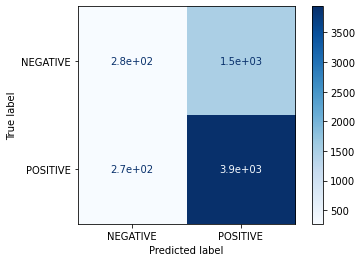

In [ ]:
model = LR(solver = 'saga')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
metrics(y_test,y_pred)
plot_confusion_matrix(model, X_test, y_test,
                      cmap=plt.cm.Blues)

In [ ]:
def LR_metrics(X_1, y_1, X_2, y_2):
  model = LR(solver = 'saga',class_weight='balanced')
  model.fit(X_1, y_1)
  y_pred = model.predict(X_2)
  metrics(y_2,y_pred)
  plot_confusion_matrix(model, X_2, y_2,
                        cmap=plt.cm.Blues)

Error 0.392415636485132
Precision 0.39224295645810464
Recall 0.6090909090909091
F1 0.4771867349209882


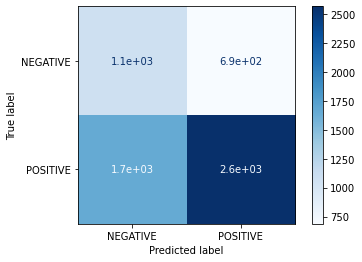

In [ ]:
LR_metrics(X_train,y_train,X_test,y_test)

# Feature Selection

In [ ]:
def feature_selection_metric(meth):
  selector = meth.fit(X_train, y_train.values.ravel())
  X_1 = selector.transform(X_train)
  X_2 = selector.transform(X_test)
  LR_metrics(X_1, y_train, X_2, y_test)

Error 0.39141329769462074
Precision 0.3946512468377304
Recall 0.6204545454545455
F1 0.4824387011265739


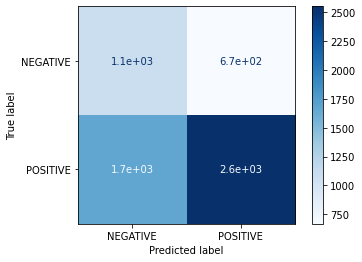

In [ ]:
from sklearn.feature_selection import SelectKBest
feature_selection_metric(SelectKBest(k=500))

Error 0.3917474106247911
Precision 0.3942898445970365
Recall 0.6198863636363636
F1 0.4819969074442235


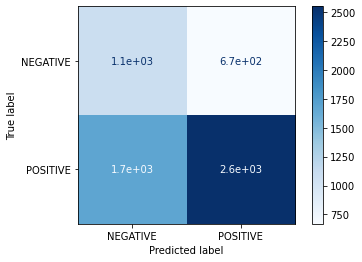

In [ ]:
from sklearn.feature_selection import VarianceThreshold
selector = SelectKBest(k=500).fit(X_train, y_train)
feature_selection_metric(selector)

Error 0.39091212829936517
Precision 0.3925925925925926
Recall 0.6022727272727273
F1 0.4753363228699552


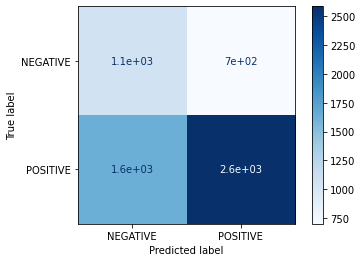

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(estimator=LinearSVC()).fit(X_train, y_train)
feature_selection_metric(selector)

Error 0.3970932175075176
Precision 0.3868720205353869
Recall 0.5994318181818182
F1 0.4702473813238244


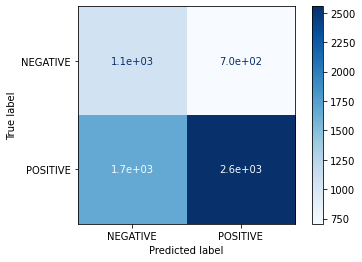

In [ ]:
selector = SelectFromModel(estimator=LR()).fit(X_train, y_train)
feature_selection_metric(selector)

Error 0.3989308386234547
Precision 0.38672438672438675
Recall 0.6090909090909091
F1 0.4730803177405119


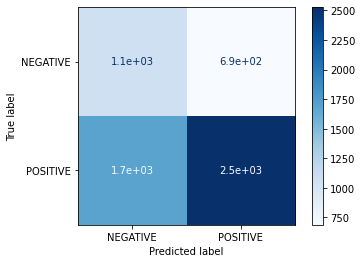

In [ ]:
from sklearn.tree import DecisionTreeClassifier
selector = SelectFromModel(estimator=DecisionTreeClassifier()).fit(X_train, y_train)
feature_selection_metric(selector)

# More complex models

Error 0.40193785499498835
Precision 0.3777441332323997
Recall 0.5670454545454545
F1 0.453430258973194


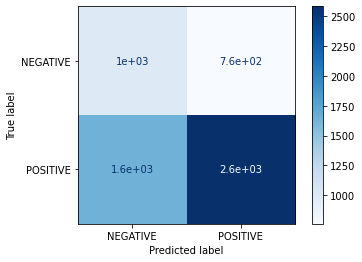

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier( DecisionTreeClassifier(max_depth = 1, class_weight='balanced'), n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

metrics(y_test, y_pred)
plot_confusion_matrix(model, X_test, y_test,
                      cmap=plt.cm.Blues)

Error 0.29034413631807554
Precision 0.5846153846153846
Recall 0.04318181818181818
F1 0.08042328042328042


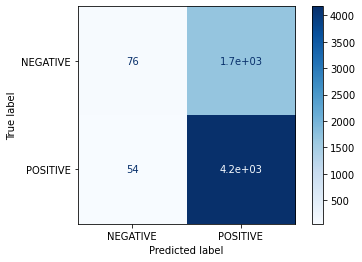

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100,class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

metrics(y_test, y_pred)
plot_confusion_matrix(model, X_test, y_test,
                      cmap=plt.cm.Blues)

Error 0.3927497494153024
Precision 0.3359244863964464
Recall 0.34375
F1 0.33979219320415616


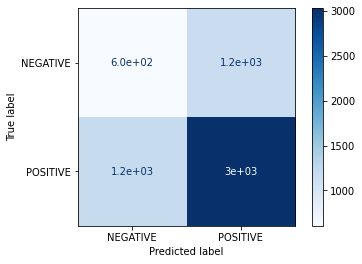

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

metrics(y_test, y_pred)
plot_confusion_matrix(model, X_test, y_test,
                      cmap=plt.cm.Blues)

Error 0.35950551286334786
Precision 0.38106796116504854
Recall 0.3568181818181818
F1 0.3685446009389671


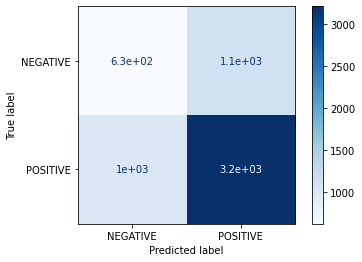

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

model = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(1000, 500))
model.fit(X_train_scale, y_train)
y_pred = model.predict(X_test_scale)

metrics(y_test, y_pred)
plot_confusion_matrix(model, X_test_scale, y_test,
                      cmap=plt.cm.Blues)